In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from torchsummary import summary
import cv2
import imageio
import os

/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
resnet50 = models.resnet50(pretrained=True)

/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
imgs_processed = []

# values for preprocessing taken from https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
preprocess = transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR), # convert h X w images to 256 X 256
        transforms.CenterCrop(224), # crop to 224 X 224
        transforms.ToTensor(), # convert PIL image to (c, h, w) tensor in range [0, 1]
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
    ])

for i in range(1, 6):
    img = Image.open(f"./images/i{i}.jpg").convert('RGB')
    img = preprocess(img)
    print
    img.requires_grad = True
    imgs_processed.append(img)
    print(f'Image {i} shape: {imgs_processed[-1].shape}')

Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


### Displaying the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


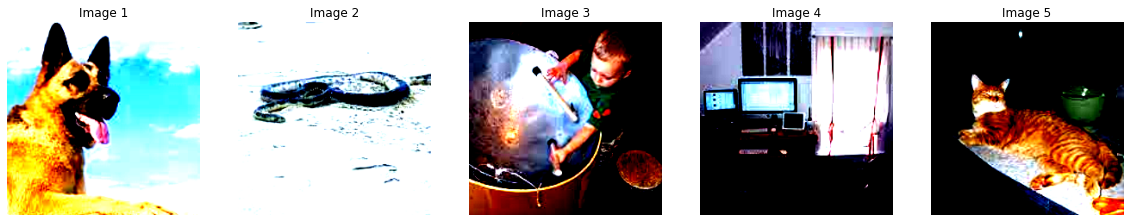

In [4]:
figure, axes = plt.subplots(1, 5, figsize=(20, 20))
# figure.set_figheight(10)
# figure.set_figwidth(10)

for i in range(5):
    axes[i].imshow(imgs_processed[i].permute(1, 2, 0).detach().numpy())
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

### 1000 labels of Resnet-50 

In [5]:
with open('resnet50_labels.txt') as f:
    labels = [line.strip() for line in f.readlines()]

### Creating a batch input of 5 images

In [6]:
batch_imgs = torch.tensor([])
resnet50.eval()
for i in range(5):
    batch_imgs = torch.cat((batch_imgs, torch.unsqueeze(imgs_processed[i], 0)), 0)

print(f'Batch image shape: {batch_imgs.shape}')

Batch image shape: torch.Size([5, 3, 224, 224])


### Running the ResNet50 model on the batch input

In [7]:
output = resnet50(batch_imgs)
print(f'Output shape: {output.shape}')

Output shape: torch.Size([5, 1000])


### Predicting Labels

In [8]:
_, indices = torch.max(output, 1)
for i in range(5):
    print(f'Image {i+1} is classified as {labels[indices[i]]} at index {indices[i]}')

Image 1 is classified as German shepherd, German shepherd dog, German police dog, alsatian at index 235
Image 2 is classified as sea snake at index 65
Image 3 is classified as steel drum at index 822
Image 4 is classified as television, television system at index 851
Image 5 is classified as tiger cat at index 282


### Q1

#### Part a:

##### Visualising gradient of loss with respect to input via vanilla backpropagation for each image

In [9]:
# printed in previous cell
actual_labels_indices = [235, 65, 822, 851, 282]

In [10]:
def vanilla_backprop_grads(model, image_index):
    # return the gradients of the image with respect to the output of the model
    # shape: (3, 224, 224)

    model.eval()
    predictions = model(torch.unsqueeze(imgs_processed[image_index], 0))
    predictions = torch.nn.functional.softmax(predictions, dim=1)

    model.zero_grad()
    actual = torch.zeros_like(predictions)
    actual[0][actual_labels_indices[image_index]] = 100
    predictions.backward(gradient=actual) 
    # takes weighted sum
    # https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments

    grad = imgs_processed[image_index].grad
    
    return grad

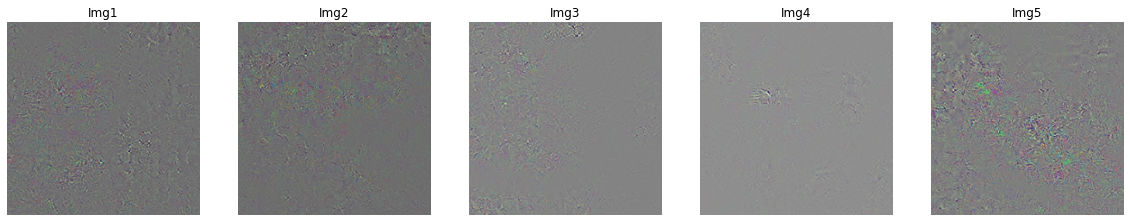

In [11]:
model = models.resnet50(pretrained=True)
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
# fig.suptitle('Gradients of the input image with respect to finally activated output', fontsize=10)
for i in range(5):
    grads = vanilla_backprop_grads(model, i)

    # recale to 0-255
    grads = grads - torch.min(grads)
    grads = grads / torch.max(grads)
    grads = grads * 255
    axes[i].imshow(grads.permute(1, 2, 0).detach().numpy().astype(np.uint8))
    axes[i].axis('off')
    axes[i].set_title(f'Img{i+1}')

##### Explaination

It can be seen that for image 3 the part at the left has postive gradients due to the drums being present there. Also in image 5, the part which contains the cat has positive gradients.

#### Part b:

##### Hook to clamp negative gradients to zero

In [12]:
def relu_backward_hook(module, grad_out, grad_in):
       modified_grad_out = torch.nn.functional.relu(grad_out[0])
       return (modified_grad_out, )

In [13]:
def guided_backprop(hooked_model, image_index):
   # return the guided gradients of the image with respect to the output of the model
   # shape: (3, 224, 224)

   hooked_model.eval()
   predictions = hooked_model(torch.unsqueeze(imgs_processed[image_index], 0))
   predictions = torch.nn.functional.softmax(predictions, dim=1)

   hooked_model.zero_grad()
   actual = torch.zeros_like(predictions)
   actual[0][actual_labels_indices[image_index]] = 1
   predictions.backward(actual) 
   # takes weighted sum
   # https://stackoverflow.com/questions/43451125/pytorch-what-are-the-gradient-arguments

   grad = imgs_processed[image_index].grad
   
   return grad

##### Register backward hook

In [14]:
model = models.resnet50(pretrained=True)
for name, module in model.named_modules():
    # print(name, isinstance(module, torch.nn.ReLU))
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_backward_hook)

/Users/aayush/venvs/EE5606_venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


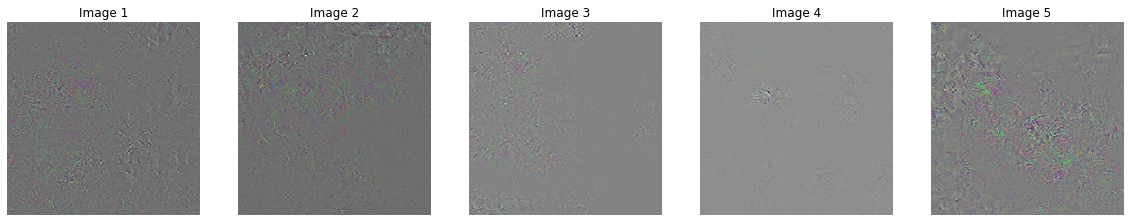

In [15]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
# fig.suptitle('Gradients of the input image with respect to finally activated output', fontsize=10)
for i in range(5):
    grads = guided_backprop(model, i)
    # recale to 0-255
    grads = grads - torch.min(grads)
    grads = grads / torch.max(grads)
    grads = grads * 255
    axes[i].imshow(grads.permute(1, 2, 0).detach().numpy().astype(np.uint8))
    axes[i].axis('off')
    axes[i].set_title(f'Image {i+1}')

#### Part c:

##### Getting the CAM weights

In [16]:
# these are the weights we will use for class activation mapping
fc_params = torch.tensor([])
for name, param in model.named_parameters():
    # print(name, param.shape)
    if name == 'fc.weight':
        fc_params = param
        print(name, param.shape)

fc.weight torch.Size([1000, 2048])


##### Register forward hook to get intermediate values

In [17]:
# register forward hook to get the 7 X 7 X 2048 output before the average pooling layer
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model = models.resnet50(pretrained=True)
# adding forward hook to the penultimate relu layer
model.layer4[2].relu.register_forward_hook(get_activation('relu'))

In [18]:
def get_weighted_CAM(forward_hooked_model, index, weights, rescale=True):
    # print(weights.shape)
    _ = forward_hooked_model(torch.unsqueeze(imgs_processed[index], 0))
    activation['relu'] = activation['relu'][0]
    activation['relu'] = activation['relu'].permute(1, 2, 0)
    # 7 X 7 X 2048 => 49 X 2048
    activation['relu'] = activation['relu'].reshape(-1, 2048)

    # class_index = actual_labels_indices[index]
    # weighted sum of the 2048 class activation maps
    activation_map = torch.matmul(activation['relu'], weights) # 49 X 1
    activation_map = activation_map.reshape(7, 7)
    
    if rescale:
        # activation_map = torch.nn.functional.relu(activation_map)
        activation_map = activation_map - torch.min(activation_map)
        activation_map = activation_map / (torch.max(activation_map) - torch.min(activation_map))
        activation_map = activation_map * 255

    return activation_map

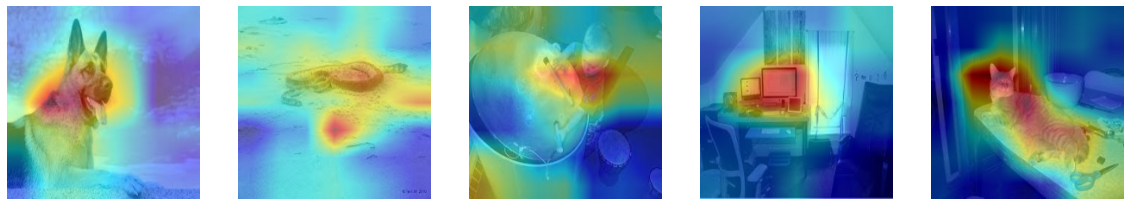

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):  
    activation_map = get_weighted_CAM(model, i, fc_params[actual_labels_indices[i]])

    activation_map = activation_map.detach().numpy().astype(np.uint8)

    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)
    activation_map = cv2.cvtColor(activation_map, cv2.COLOR_BGR2RGB)
    original_image = cv2.imread(f'images/i{i+1}.jpg')
    original_image = cv2.resize(original_image, (224, 224))
    activation_map = cv2.addWeighted(original_image, 0.5, activation_map, 0.5, 0)

    axes[i].imshow(activation_map)
    axes[i].axis('off')

#### Part d:

##### Registering forward and backward hooks for Guided backprop and CAM

In [20]:
model = models.resnet50(pretrained=True)

for name, module in model.named_modules():
    # print(name, isinstance(module, torch.nn.ReLU))
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_backward_hook)

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.layer4[2].relu.register_forward_hook(get_activation('relu'))

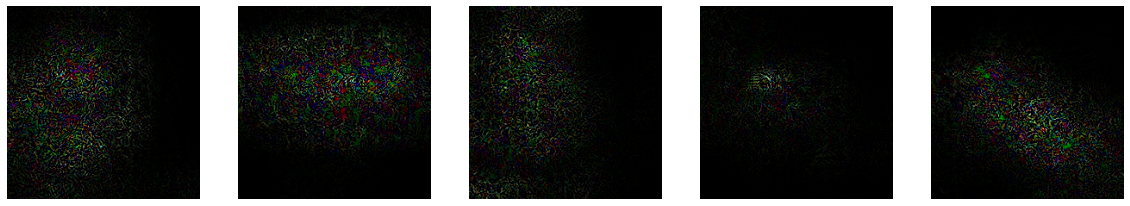

In [21]:
fig, axes = plt.subplots(1, 5, figsize=(20, 20))

for i in range(5):
    guided_backprop_grads = guided_backprop(model, i).permute(1, 2, 0)

    guided_backprop_grads = torch.nn.functional.relu(guided_backprop_grads)
    guided_backprop_grads = guided_backprop_grads ** 0.6
    guided_backprop_grads = guided_backprop_grads - torch.min(guided_backprop_grads)
    guided_backprop_grads = guided_backprop_grads / torch.max(guided_backprop_grads)
    guided_backprop_grads = guided_backprop_grads * 255
    
    activation_map = get_weighted_CAM(model, i, fc_params[actual_labels_indices[i]], rescale=True)
    activation_map = activation_map.detach().numpy().astype(np.uint8)
    activation_map = cv2.resize(activation_map, (224, 224))
    activation_map = torch.tensor(activation_map)
    activation_map = activation_map.unsqueeze(2).repeat(1, 1, 3)
    
    # print(guided_backprop_grads.shape)
    # print(activation_map.shape)

    guided_grad_cam = guided_backprop_grads * activation_map
    
    # print(guided_grad_cam.shape)
    guided_grad_cam = guided_grad_cam - torch.min(guided_grad_cam)
    guided_grad_cam = guided_grad_cam / torch.max(guided_grad_cam)
    guided_grad_cam = guided_grad_cam * 255
    
    axes[i].imshow(guided_grad_cam.detach().numpy().astype(np.uint8))
    axes[i].axis('off')

### Q2

##### Gradients

In [22]:
# Gradients of 10 x ^ 2 + y ^ 2 with respect to x and y
def get_gradients(x):
    return torch.tensor([20 * x[0], 2 * x[1]])

#### SGD

In [23]:
def SGD(initial_point, num_iters= 50, alpha= 0.01):
    path = torch.zeros((num_iters, 2))

    for i in range(num_iters):
        # print(initial_point)
        path[i] = initial_point
        grads = get_gradients(path[i])
        initial_point = initial_point - alpha * grads

    path[num_iters - 1] = initial_point
    return path

In [24]:
initial_point = torch.tensor([18., 18.])
sgd = SGD(initial_point, alpha= 0.08)

#### SGD With Momentum

In [25]:
def SGD_with_momentum(initial_point, num_iters= 50, alpha= 0.01, beta= 0.9):
    path = torch.zeros((num_iters, 2))
    v = torch.zeros(2)

    for i in range(num_iters):
        # print(initial_point)
        path[i] = initial_point
        grads = get_gradients(path[i])
        v = beta * v + grads
        initial_point = initial_point - alpha * v

    path[num_iters - 1] = initial_point
    return path

In [26]:
initial_point = torch.tensor([18., 18.])
sgd_with_mom = SGD_with_momentum(initial_point, alpha= 0.01, beta= 0.09)

#### Nesterov Momentum

In [27]:
def nesterov_momentum(initial_point, num_iters= 50, alpha= 0.1, beta= 0.9):

    path = torch.zeros((num_iters, 2))
    v = torch.zeros(2)

    for i in range(num_iters):
        path[i] = initial_point
        
        grads = get_gradients(path[i] + beta * v)
        v = beta * v - alpha * grads
        initial_point += alpha*v
    
    path[num_iters - 1] = initial_point
    return path

In [28]:
initial_point = torch.tensor([18., 18.])
nest_mom = nesterov_momentum(initial_point, alpha= 0.1, beta= 0.8)

#### AdaGrad

In [29]:
def AdaGrad(initial_point, num_iters = 50, alpha = 0.1, epsilon = 1):

    path = torch.zeros((num_iters, 2))
    grad_sq = torch.zeros(2)

    for i in range(num_iters):
        path[i] = initial_point
        grads = get_gradients(path[i])
        grad_sq += grads ** 2
        initial_point = initial_point - alpha * grads / (grad_sq ** 0.5 + epsilon)
    
    path[num_iters - 1] = initial_point
    return path

In [30]:
initial_point = torch.tensor([18., 18.])
ada_grad = AdaGrad(initial_point, alpha= 4)

#### RMSProp

In [31]:
def RMSProp(initial_point, num_iters = 50, alpha = 0.5, epsilon = 1, rho = 0.99):
    path = torch.zeros((num_iters, 2))
    grad_sq = torch.zeros(2)

    for i in range(num_iters):
        path[i] = initial_point
        grads = get_gradients(path[i])
        grad_sq = rho * grad_sq + (1 - rho) * grads ** 2

        initial_point = initial_point - alpha * grads / (grad_sq ** 0.5 + epsilon)

    path[num_iters - 1] = initial_point
    return path

In [32]:
initial_point = torch.tensor([18., 18.])
rms_prop = RMSProp(initial_point, alpha= 0.5)

#### Creating the GIF

In [33]:
def save_frame_at_iteration(iteration):
    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = 10 * X ** 2 + Y ** 2
    plt.contour(X, Y, Z, levels= 20, cmap= 'RdGy')
    plt.scatter(sgd[:iteration, 0], sgd[:iteration, 1], c='b', label="SGD")
    plt.scatter(sgd_with_mom[:iteration, 0], sgd_with_mom[:iteration, 1], c='c', label="SGD with Momentum")
    plt.scatter(nest_mom[:iteration, 0], nest_mom[:iteration, 1], c='g', label= "Nesterov Momentum")
    plt.scatter(ada_grad[:iteration, 0], ada_grad[:iteration, 1], c='m', label= "AdaGrad")
    plt.scatter(rms_prop[:iteration, 0], rms_prop[:iteration, 1], c='r', label="RMSProp")
    plt.grid(visible=True, axis='both')

    plt.xlim([-20, 20])
    plt.xlabel('x')
    plt.ylim([-20, 20])
    plt.ylabel('y')
    plt.title(f'Iteration {iteration + 1}')
    plt.legend()
    plt.savefig(f'.{iteration}_DL.png')
    plt.close()

for iteration in range(51):
    save_frame_at_iteration(iteration)

frames = []
for iteration in range(51):
    frame = imageio.v2.imread(f'.{iteration}_DL.png')
    frames.append(frame)

imageio.mimsave('update_rules.gif',frames, fps = 4)   

for iteration in range(51):
    os.remove(f'.{iteration}_DL.png')

In [34]:
from torchsummary import summary
summary(model, (3, 224, 224))
# print(model.modules)
# print(model)
# print(model.avgpool)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]         16,38